<a href="https://colab.research.google.com/github/Thames07/Apply-Uniabuja_Student_Alcholic_Consumption/blob/main/ARIMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### code in Python for Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) using the statsmodels library:

In [89]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame


In [70]:
df = pd.read_csv('/content/drive/MyDrive/AirPassengers.csv')
df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [71]:
#We need to set the Month column as index and convert it into datetime
df.set_index('Month',inplace=True)
df.index=pd.to_datetime(df.index)
 
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<Axes: xlabel='Month'>

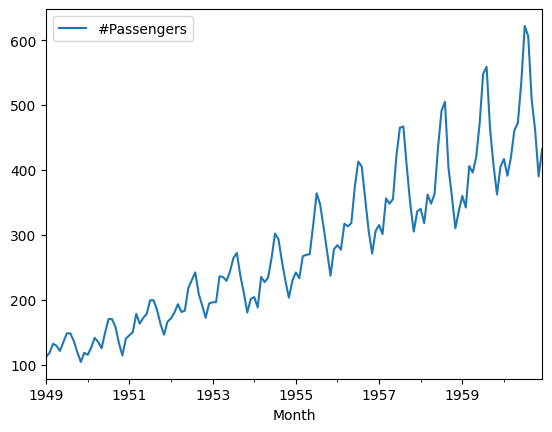

In [72]:

df.plot()

As you can clearly see, there is a trend in time and that suggests that the data are not stationary. However just to be sure we will use an Augmented Dickey-Fuller test.

In [73]:
from statsmodels.tsa.stattools import adfuller
 
result=adfuller(df['#Passengers'])
 
#to help you, we added the names of every value
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': 0.8153688792060498,
 'pvalue': 0.991880243437641,
 'usedlag': 13,
 'nobs': 130,
 'criticalvalues': {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 'icbest': 996.692930839019}

Transform Non-Stationary to Stationary using Differencing (the d and D parameters)
The next step is to transform our data to Stationary so we will have an estimate for d and D parameters we will use in the model. This can be done using Differencing and it’s performed by subtracting the previous observation from the current observation.

difference(T) = observation(T) – observation(T-1)

Then, we will test it again for stationarity using the Augmented Dickey-Fuller test and if it’s stationary we will proceed to our next step. If not we will apply differencing again till we have a stationary series. Differencing can be done very easily with pandas using the shift function.

<Axes: xlabel='Month'>

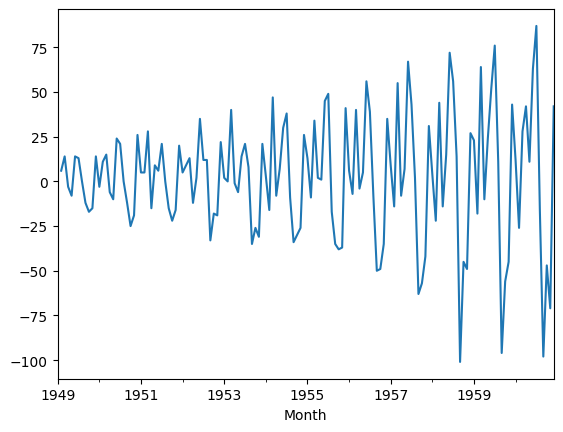

In [74]:
df['1difference']=df['#Passengers']-df['#Passengers'].shift(1)
 
df['1difference'].plot()

It seems that we removed the trend and the series is Stationary. However we will use the Augmented Dickey-Fuller test to proove it.

In [75]:
#note we are dropping na values because the first value of the first difference is NA 
 
result=adfuller(df['1difference'].dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -2.8292668241700047,
 'pvalue': 0.05421329028382478,
 'usedlag': 12,
 'nobs': 130,
 'criticalvalues': {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 'icbest': 988.5069317854085}

<Axes: xlabel='Month'>

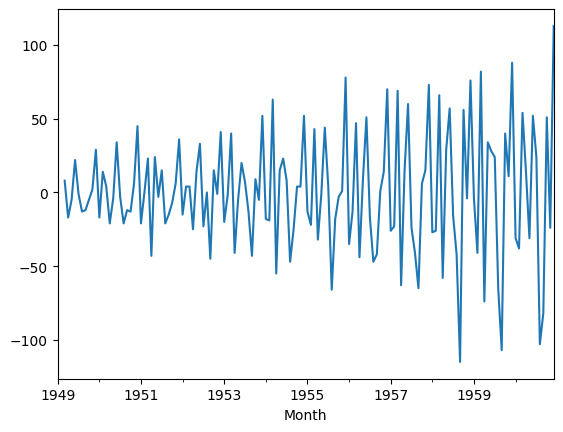

In [80]:
df['2difference']=df['1difference']-df['1difference'].shift(1)
 
df['2difference'].plot()

In [81]:
result=adfuller((df['2difference']).dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -16.384231542468513,
 'pvalue': 2.7328918500142026e-29,
 'usedlag': 11,
 'nobs': 130,
 'criticalvalues': {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 'icbest': 988.6020417275611}

The p-value is less than 0.05 so we can reject the null hypothesis. That means the second difference is stationary and that suggests that a good estimate for the value d is 2.

Our data are seasonal so we need to estimate also the D value which is the same as the d value but for Seasonal Difference. The seasonal difference can be computed by shifting the data by the number of rows per season (in our example 12 months per year) and subtracting them from the previous season. This is not the first seasonal difference. If we get that the seasonal difference is stationary then the D value will be 0. If not then we will compute the seasonal first difference.

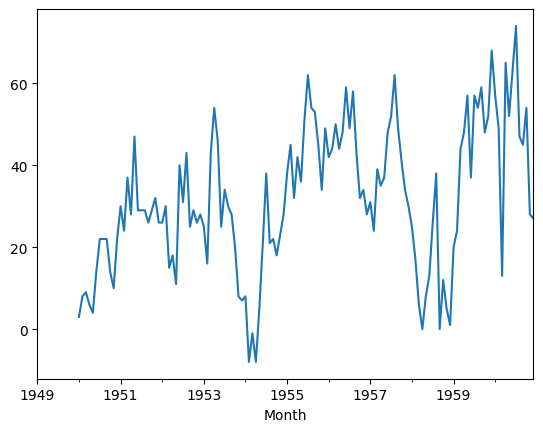

In [82]:
df['Seasonal_Difference']=df['#Passengers']-df['#Passengers'].shift(12)
ax=df['Seasonal_Difference'].plot()

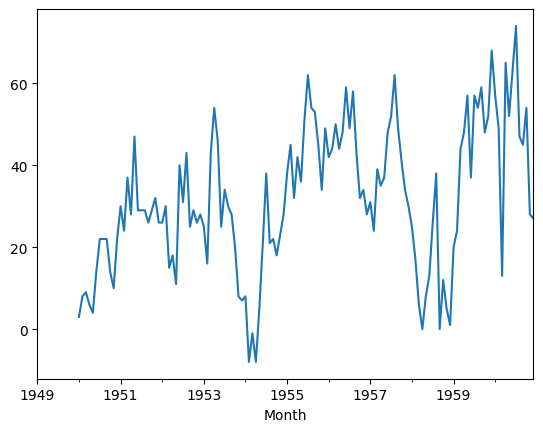

In [83]:
df['Seasonal_Difference']=df['#Passengers']-df['#Passengers'].shift(12)
ax=df['Seasonal_Difference'].plot()

The p-value is less than 0.05 thus it’s stationary and we don’t have to use differencing. That suggests to use 0 for the D value.

Autocorrelation and Partial Autocorrelation Plots (p,q and P,Q parameters)
The last step before the ARIMA model is to create the Autocorrelation and Partial Autocorrelation Plots to help us estimate the p,q, P, and Q parameters.

There are some very useful rules for ARIMA and Seasonal ARIMA models that we are using to help us estimate the parameters by looking at the Autocorrelation and Partial Autocorrelation Plots. We will create the plots for the second difference and the seasonal difference of our time series because these are the stationary series we end up using in ARIMA (d=2, D=0).

First, let’s plot ACF and PACF for the second difference.

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


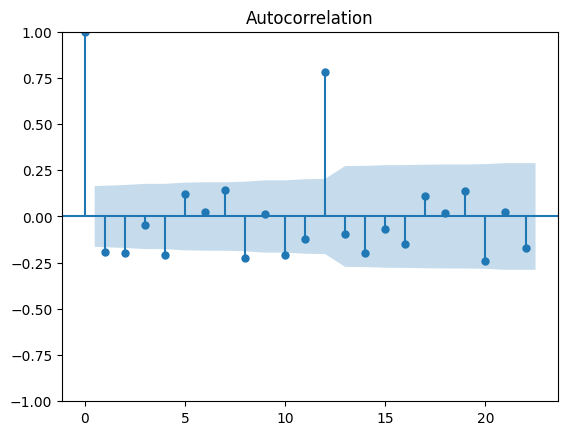

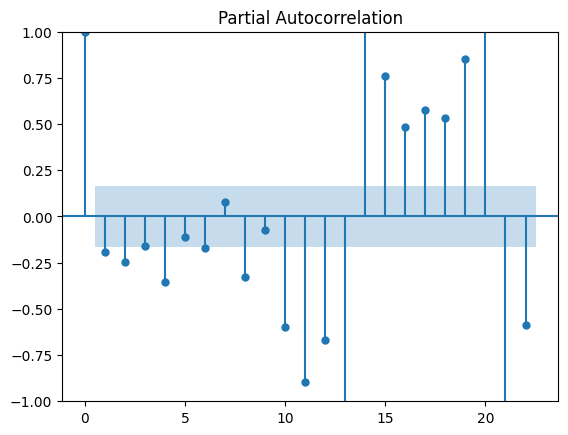

In [84]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
 
fig1=plot_acf(df['2difference'].dropna()) 
fig2=plot_pacf(df['2difference'].dropna())

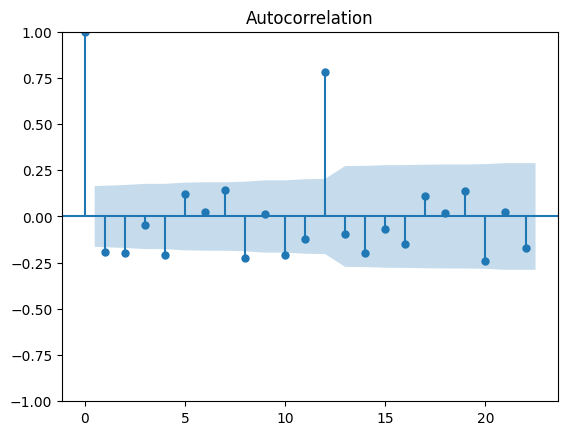

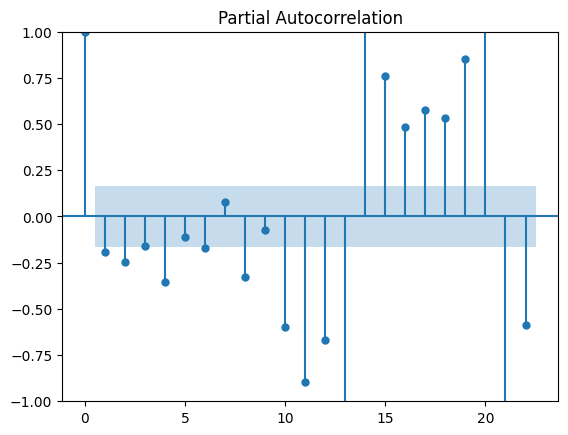

In [85]:

fig1=plot_acf(df['2difference'].dropna()) 
fig2=plot_pacf(df['2difference'].dropna())

We have a gradual decrease in the Autocorrelation plot and a sharp cut-off in the Partial Autocorrelation plot. This suggests using AR and not over the value of 1 for the seasonal part of the ARIMA.

The values we chose may not be optimum. You can play around with these parameters to fine-tune the model having as a guide the rules we mentioned above.

#### The ARIMA Model

In [90]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(df['#Passengers'],order=(1,2,1),seasonal_order=(1, 0, 0, 12))
result=model.fit()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: ylabel='Density'>

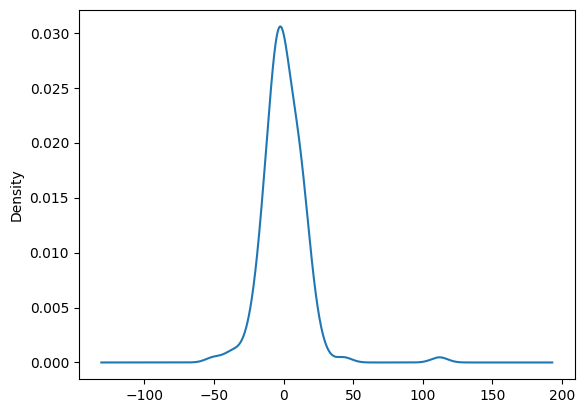

In [91]:
result.resid.plot(kind='kde')

In [88]:
from pandas.tseries.offsets import DateOffset
new_dates=[df.index[-1]+DateOffset(months=x) for x in range(1,48)]
df_pred=pd.DataFrame(index=new_dates,columns =df.columns)
df_pred.head()

,#Passengers,1difference,2difference,Seasonal_Difference
1961-01-01,NaN,NaN,NaN,NaN
1961-02-01,NaN,NaN,NaN,NaN
1961-03-01,NaN,NaN,NaN,NaN
1961-04-01,NaN,NaN,NaN,NaN
1961-05-01,NaN,NaN,NaN,NaN


<Axes: >

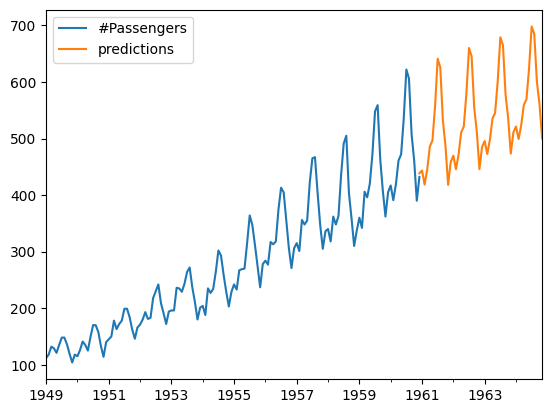

In [92]:
df2=pd.concat([df,df_pred])
 
 
df2['predictions']=result.predict(start=143,end=191)
df2[['#Passengers','predictions']].plot()